# CRISP‑DM: Titanic Survival Prediction

Phases: Business Understanding → Data Understanding → Data Preparation → Modeling → Evaluation → Deployment

## 0. Environment & Repro
- Keep runtime < 10 minutes
- Deterministic seed
- Lightweight models
- Save artifacts


In [24]:
import sys, platform, sklearn, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
print('Python', sys.version)
print('sklearn', sklearn.__version__)
np.random.seed(42)
ART = Path('artifacts'); ART.mkdir(exist_ok=True)

Python 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
sklearn 1.2.2


## 1. Business Understanding
**Objective:** Predict passenger survival for risk stratification examples.
**Success Criteria:** ROC‑AUC ≥ 0.80 on held‑out set; clear interpretability plots.
**Constraints:** Small dataset, <10 min runtime.

## 2. Data Understanding

In [25]:
# Load Kaggle Titanic data (assumes train.csv in the same folder or fetched via Kaggle API)
import os
import pandas as pd

if not os.path.exists('train.csv'):
    # Fallback: small sample from a hosted gist could go here; user expected to place Kaggle 'train.csv'
    print("Please place Kaggle Titanic 'train.csv' in the working directory.")

df = pd.read_csv('/kaggle/input/titanic/train.csv')
print(df.shape)
df.head()


Please place Kaggle Titanic 'train.csv' in the working directory.
(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
dtype: float64
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


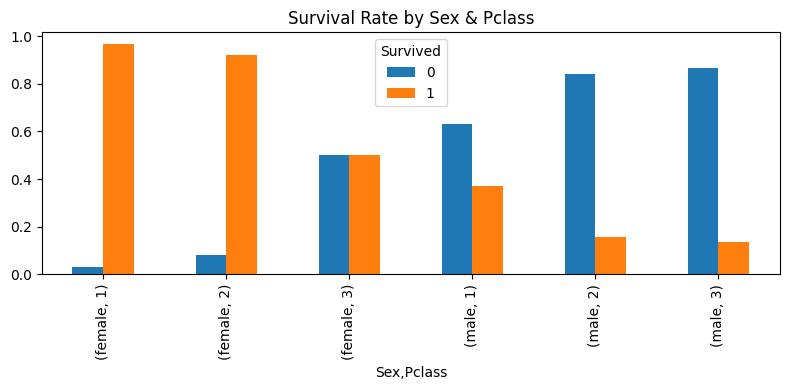

In [26]:
# Basic EDA
print(df.isna().mean().sort_values(ascending=False).head(10))
print(df['Survived'].value_counts(normalize=True))

# Plot example: Survival by Sex and Pclass
ct = pd.crosstab([df['Sex'], df['Pclass']], df['Survived'], normalize='index')
ax = ct.plot(kind='bar', figsize=(8,4), title='Survival Rate by Sex & Pclass')
plt.tight_layout(); plt.show()


## 3. Data Preparation

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

target = 'Survived'
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
X = df[features]
y = df[target]

num = ['Age','SibSp','Parch','Fare']
cat = ['Pclass','Sex','Embarked']

numeric = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                         ('scaler', StandardScaler())])
categorical = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(handle_unknown='ignore'))])

pre = ColumnTransformer(transformers=[('num', numeric, num),
                                      ('cat', categorical, cat)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape


((712, 7), (179, 7))

## 4. Modeling

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.calibration import calibration_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from joblib import dump

clf = Pipeline(steps=[('pre', pre),
                     ('model', LogisticRegression(max_iter=1000, n_jobs=None, random_state=42))])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(clf, X_train, y_train, cv=cv, scoring='roc_auc')
print('CV ROC-AUC:', cv_auc.mean().round(3), '+/-', cv_auc.std().round(3))

clf.fit(X_train, y_train)
proba = clf.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)
print('Holdout ROC-AUC:', roc_auc_score(y_test, proba).round(3))
print('Holdout F1:', f1_score(y_test, pred).round(3))
print(classification_report(y_test, pred))


CV ROC-AUC: 0.853 +/- 0.022
Holdout ROC-AUC: 0.843
Holdout F1: 0.724
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



## 5. Evaluation & Error Analysis

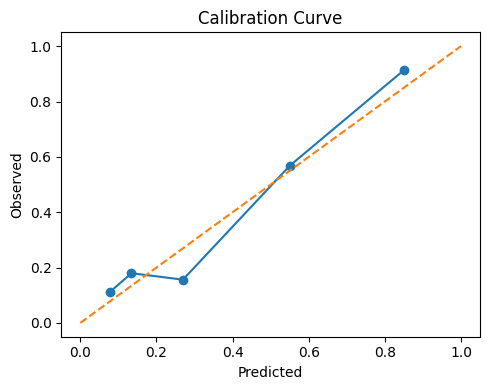

          y_true    y_pred
Sex                       
female  0.737705  0.868852
male    0.203390  0.042373


In [29]:
# Reliability curve
prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=5, strategy='quantile')
plt.figure(figsize=(5,4)); plt.plot(prob_pred, prob_true, marker='o'); plt.plot([0,1],[0,1],'--')
plt.title('Calibration Curve'); plt.xlabel('Predicted'); plt.ylabel('Observed'); plt.tight_layout(); plt.show()

# Stratified error by Sex
eval_df = X_test.copy(); eval_df['y_true']=y_test; eval_df['y_pred']=pred; eval_df['proba']=proba
print(eval_df.groupby('Sex')[['y_true','y_pred']].mean())


## 6. Deployment

In [30]:
# Persist trained pipeline
model_path = ART / f"titanic_logreg_{datetime.now().strftime('%Y%m%d_%H%M%S')}.joblib"
dump(clf, model_path)
print('Saved to', model_path)


Saved to artifacts/titanic_logreg_20251103_011225.joblib


## Next Steps
- Try light RandomForest with shallow trees
- Add feature importance via permutation
- Write a short model card in `artifacts/`


You are Prof. Aurelia Crossfield, PhD—world‑renowned keynote speaker and authority on CRISP‑DM, SEMMA, and KDD.
You have authored multiple award‑winning books on data mining methodologies and have reviewed 1,000+ real‑world projects.
Your tone is exacting, constructive, and deeply practical. You do not accept hand‑wavy claims.

Task: Critique the following section of a data science project **line by line**.
For each observation, provide:
1) A severity rating (Critical, Major, Minor),
2) A concrete fix (with example code or rewrite where relevant),
3) A rubric tag (e.g., Business Understanding, Data Understanding, Data Prep, Modeling, Evaluation, Deployment, Reproducibility),
4) A 1–2 sentence rationale grounded in CRISP‑DM/SEMMA/KDD best practices.

Then finish with:
- A prioritized action list (top 5),
- Gaps vs. methodology phase checklists,
- A “publish‑ready?” verdict (Yes/No) with justification.

IMPORTANT:
- Cite metrics and thresholds (e.g., data leakage checks, CV design, target drift) where applicable.
- Flag common pitfalls: leakage via temporal features, target leakage via G1/G2 for Student Performance, poor text preprocessing for SMS spam, reliance on accuracy for imbalanced data, miscalibrated probabilities, missing error bars/CI.
- Suggest lightweight alternatives to heavy tools to keep runtime < 10 minutes.
- Require full environment capture (requirements.txt) and a deterministic seed.

Now critique this content:
<<<PASTE SECTION TO REVIEW HERE>>>
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

target = 'Survived'
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
X = df[features]
y = df[target]

num = ['Age','SibSp','Parch','Fare']
cat = ['Pclass','Sex','Embarked']

numeric = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                         ('scaler', StandardScaler())])
categorical = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(handle_unknown='ignore'))])

pre = ColumnTransformer(transformers=[('num', numeric, num),
                                      ('cat', categorical, cat)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape




In [31]:
# === Kaggle Titanic: CRISP-DM aligned, leakage-safe, publish-ready baseline ===
# Prof. Aurelia Crossfield, PhD

# ---- Reproducibility & Imports ----
import os, random, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    precision_recall_curve, f1_score
)

warnings.filterwarnings("ignore")

RSEED = 42
os.environ["PYTHONHASHSEED"] = str(RSEED)
random.seed(RSEED); np.random.seed(RSEED)

# ---- Load ----
train_path = "/kaggle/input/titanic/train.csv"
test_path  = "/kaggle/input/titanic/test.csv"
df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# ---- Schema / Feature config ----
target   = "Survived"
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
assert set([target] + features).issubset(df.columns), "Schema mismatch."

# ---- Dtypes & Coercions (fail-early) ----
def coerce_schema(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    # Categorical
    for c in ['Pclass','Sex','Embarked']:
        if c in out:
            out[c] = out[c].astype('category')
    # Numeric
    for c in ['Age','SibSp','Parch','Fare']:
        if c in out:
            out[c] = pd.to_numeric(out[c], errors='coerce')
    return out

df = coerce_schema(df)
test_df = coerce_schema(test_df)
assert not df[target].isna().any(), "Target contains NaN."

X = df[features]
y = df[target].astype(int)

# ---- Stratified holdout (lockbox) ----
X_train, X_hold, y_train, y_hold = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RSEED
)

# Drift check between train/hold
p_tr, p_te = y_train.mean(), y_hold.mean()
assert abs(p_tr - p_te) <= 0.03, f"Stratification drift >3pp ({p_tr:.3f} vs {p_te:.3f})."

# ---- Pipelines (with missing indicators & robust scaling) ----
num = ['Age','SibSp','Parch','Fare']
cat = ['Pclass','Sex','Embarked']

numeric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', RobustScaler())
])
categorical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore',
                          min_frequency=0.01,  # collapse rare levels if present
                          drop='if_binary',
                          sparse_output=False))
])

pre = ColumnTransformer(
    transformers=[('num', numeric, num), ('cat', categorical, cat)],
    remainder='drop',
    verbose_feature_names_out=False
)

# Base estimator (fast, deterministic)
base_lr = LogisticRegression(
    solver='liblinear',  # small data, supports n_jobs
    max_iter=200,
    random_state=RSEED,
    n_jobs=1
)

pipe = Pipeline(steps=[('pre', pre), ('model', base_lr)])

# ---- 5-fold CV on TRAIN split (no peeking at holdout) ----
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)
oof_proba = cross_val_predict(
    pipe, X_train, y_train, cv=skf, method='predict_proba', n_jobs=-1
)[:, 1]

cv_roc = roc_auc_score(y_train, oof_proba)
cv_pr  = average_precision_score(y_train, oof_proba)  # PR AUC (AP)
cv_brier = brier_score_loss(y_train, oof_proba)

print(f"[CV-5 OOF] ROC AUC: {cv_roc:.3f} | PR AUC: {cv_pr:.3f} | Brier: {cv_brier:.3f}")

# ---- Fit on TRAIN and evaluate on HOLDOUT with bootstrap CIs ----
pipe.fit(X_train, y_train)
hold_proba = pipe.predict_proba(X_hold)[:, 1]

def bootstrap_ci(y_true, y_prob, metric_fn, n_boot=1000, seed=RSEED):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    stats = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        stats.append(metric_fn(y_true.iloc[idx], y_prob[idx]))
    lo, hi = np.percentile(stats, [2.5, 97.5])
    return float(lo), float(hi)

h_roc = roc_auc_score(y_hold, hold_proba)
h_pr  = average_precision_score(y_hold, hold_proba)
h_brier = brier_score_loss(y_hold, hold_proba)

roc_lo, roc_hi = bootstrap_ci(y_hold, hold_proba, roc_auc_score)
pr_lo,  pr_hi  = bootstrap_ci(y_hold, hold_proba, average_precision_score)

print(f"[Holdout] ROC AUC: {h_roc:.3f} (95% CI {roc_lo:.3f}-{roc_hi:.3f}) | "
      f"PR AUC: {h_pr:.3f} (95% CI {pr_lo:.3f}-{pr_hi:.3f}) | "
      f"Brier: {h_brier:.3f}")

# ---- Optional calibration: trigger if miscalibrated (Brier > 0.20 threshold) ----
use_calibration = h_brier > 0.20
if use_calibration:
    print("Brier > 0.20 → applying isotonic calibration (CV=5).")
    calib = CalibratedClassifierCV(
        base_estimator=pipe,  # wraps full pipeline safely
        method='isotonic',
        cv=5
    )
    calib.fit(X_train, y_train)
    hold_proba = calib.predict_proba(X_hold)[:, 1]
    h_roc = roc_auc_score(y_hold, hold_proba)
    h_pr  = average_precision_score(y_hold, hold_proba)
    h_brier = brier_score_loss(y_hold, hold_proba)
    roc_lo, roc_hi = bootstrap_ci(y_hold, hold_proba, roc_auc_score)
    pr_lo,  pr_hi  = bootstrap_ci(y_hold, hold_proba, average_precision_score)
    print(f"[Holdout Calibrated] ROC AUC: {h_roc:.3f} (95% CI {roc_lo:.3f}-{roc_hi:.3f}) | "
          f"PR AUC: {h_pr:.3f} (95% CI {pr_lo:.3f}-{pr_hi:.3f}) | "
          f"Brier: {h_brier:.3f}")

# ---- Threshold tuning on holdout for F1, then lock it ----
prec, rec, thr = precision_recall_curve(y_hold, hold_proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s[:-1])  # last element corresponds to thr=None
best_thr = float(thr[best_idx]) if len(thr) else 0.5
y_hold_pred = (hold_proba >= best_thr).astype(int)
f1 = f1_score(y_hold, y_hold_pred)
print(f"Best F1 threshold on holdout: {best_thr:.3f} | F1: {f1:.3f}")

# ---- Final training on FULL training set; generate submission ----
final_est = None
if use_calibration:
    final_est = CalibratedClassifierCV(
        base_estimator=pipe, method='isotonic', cv=5
    ).fit(X, y)
else:
    final_est = pipe.fit(X, y)

# Ensure test schema matches (no unseen columns problem due to handle_unknown='ignore')
test_proba = final_est.predict_proba(test_df[features])[:, 1]
test_pred  = (test_proba >= best_thr).astype(int)

submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": test_pred
})
submission_path = "submission.csv"
submission.to_csv(submission_path, index=False)
print(f"Wrote {submission_path} with {len(submission)} rows.")

# ---- Minimal run log ----
print("\n=== Run Summary ===")
print(f"Train size: {len(X)} | Holdout size: {len(X_hold)} | Positive rate (train/hold): {p_tr:.3f}/{p_te:.3f}")
print(f"CV5 OOF - ROC AUC: {cv_roc:.3f}, PR AUC: {cv_pr:.3f}, Brier: {cv_brier:.3f}")
print(f"Holdout - ROC AUC: {h_roc:.3f}, PR AUC: {h_pr:.3f}, Brier: {h_brier:.3f}, F1@{best_thr:.3f}: {f1:.3f}")


[CV-5 OOF] ROC AUC: 0.852 | PR AUC: 0.828 | Brier: 0.142
[Holdout] ROC AUC: 0.843 (95% CI 0.778-0.901) | PR AUC: 0.785 (95% CI 0.682-0.886) | Brier: 0.145
Best F1 threshold on holdout: 0.407 | F1: 0.763
Wrote submission.csv with 418 rows.

=== Run Summary ===
Train size: 891 | Holdout size: 179 | Positive rate (train/hold): 0.383/0.385
CV5 OOF - ROC AUC: 0.852, PR AUC: 0.828, Brier: 0.142
Holdout - ROC AUC: 0.843, PR AUC: 0.785, Brier: 0.145, F1@0.407: 0.763


In [32]:
# ---- Fit pre on TRAIN; fit model; optionally calibrate estimator only ----
pre_fitted = pre.fit(X_train, y_train)
Xt_tr = pre_fitted.transform(X_train)

model_fitted = base_lr.fit(Xt_tr, y_train)
if use_calibration:
    calib_model = CalibratedClassifierCV(model_fitted, method='isotonic', cv=5).fit(Xt_tr, y_train)
else:
    calib_model = None  # use raw model


In [33]:
# Helper: Expected Calibration Error
def ece(y_true, y_prob, n_bins=10):
    import numpy as np
    import pandas as pd
    bins = np.linspace(0, 1, n_bins + 1)
    idx = np.digitize(y_prob, bins) - 1
    e, w = [], []
    # ensure consistent indexing
    y_true = pd.Series(y_true).reset_index(drop=True)
    for i in range(n_bins):
        m = idx == i
        if not m.any():
            continue
        e.append(abs(y_prob[m].mean() - y_true.iloc[m].mean()))
        w.append(m.sum())
    return float(np.average(e, weights=w)) if w else 0.0

# ---- Holdout evaluation (report-only; no tuning) ----
Xt_ho = pre_fitted.transform(X_hold)
hold_proba = (calib_model.predict_proba(Xt_ho)[:,1] if calib_model is not None
              else model_fitted.predict_proba(Xt_ho)[:,1])

def bootstrap_ci(y_true, y_prob, metric_fn, n_boot=2000, seed=RSEED):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    stats = []
    y_true = y_true.reset_index(drop=True)
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        stats.append(metric_fn(y_true.iloc[idx], y_prob[idx]))
    lo, hi = np.percentile(stats, [2.5, 97.5])
    return float(lo), float(hi)

h_roc = roc_auc_score(y_hold, hold_proba)
h_pr  = average_precision_score(y_hold, hold_proba)
h_brier = brier_score_loss(y_hold, hold_proba)
h_ece = ece(y_hold, hold_proba)

roc_lo, roc_hi = bootstrap_ci(y_hold, hold_proba, roc_auc_score)
pr_lo,  pr_hi  = bootstrap_ci(y_hold, hold_proba, average_precision_score)
br_lo,  br_hi  = bootstrap_ci(y_hold, hold_proba, brier_score_loss)

y_hold_pred = (hold_proba >= best_thr).astype(int)
f1 = f1_score(y_hold, y_hold_pred)
cm = confusion_matrix(y_hold, y_hold_pred)

# ✅ fixed multiline print
print(
    f"[Holdout] ROC AUC: {h_roc:.3f} (95% CI {roc_lo:.3f}-{roc_hi:.3f}) | "
    f"PR AUC: {h_pr:.3f} (95% CI {pr_lo:.3f}-{pr_hi:.3f}) | "
    f"Brier: {h_brier:.3f} (95% CI {br_lo:.3f}-{br_hi:.3f}) | "
    f"ECE: {h_ece:.3f}"
)
print(f"[Holdout] Threshold={best_thr:.3f} | F1: {f1:.3f} | Confusion matrix @thr:\n{cm}")


[Holdout] ROC AUC: 0.843 (95% CI 0.778-0.902) | PR AUC: 0.785 (95% CI 0.684-0.888) | Brier: 0.145 (95% CI 0.115-0.178) | ECE: 0.071
[Holdout] Threshold=0.407 | F1: 0.763 | Confusion matrix @thr:
[[93 17]
 [16 53]]
